## Constrain HOD priors

This notebook includes code to fit the relationship between n(z) and HOD parameters. Nets trained on simulation data are applied to observational catalogs to constrain reasonable HOD parameters for simulation, marginalized over cosmology.

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os
from os.path import join
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import torch
import seaborn as sns
import pandas as pd
import warnings
from tqdm import tqdm
import h5py


import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior


def torch_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("CUDA is available. Using GPU.")
    else:
        device = torch.device("cpu")
        print("CUDA is not available. Using CPU.")
    return device


device = torch_device()

# Suppress warnings
warnings.filterwarnings('ignore')

/home/x-mho1/.conda/envs/2024.02-py311/cmass/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA is not available. Using CPU.


In [2]:
wdir = '/anvil/scratch/x-mho1/cmass-ili'

In [18]:
# Training simulation

# # SIMBIG/SGC/MTNG
# nbody = 'mtnglike'
# sim = 'fastpm_recnoise_rot'
# L, N = 3000, 384
# Nsims = 3000
# tracer = 'simbig_lightcone'

# NGC
nbody = 'mtnglike'
sim = 'fastpm_recnoise'
L, N = 3000, 384
Nsims = 3000
tracer = 'ngc_lightcone'

suitedir = join(wdir, nbody, sim, f'L{L}-N{N}')

In [19]:
lhidlist = os.listdir(suitedir)
lhid = lhidlist[0]

x = []
theta = []
for lhid in tqdm(lhidlist):
    filedir = join(suitedir, lhid, 'diag', tracer)
    if not os.path.isdir(filedir):
        continue
    filelist = os.listdir(filedir)

    if len(filelist) == 0:
        continue
    file = filelist[0]
    with h5py.File(join(filedir, file), 'r') as f:
        nzbins = f['nz_bins'][:]
        x.append(f['nz'][:])
        theta.append(f.attrs['HOD_params'][10:13])  # logMmin parameters

x = np.array(x)
theta = np.array(theta)

# averaging into 10 redshift bins
nzcens = 0.5 * (nzbins[:-1] + nzbins[1:])
x = np.log10(np.sum(x.reshape(len(x), -1, 10), axis=-1))

if tracer == 'simbig_lightcone':
    # ignore the 0 redshift bins if simbig
    x = x[:, 1:7]

100%|██████████| 3000/3000 [00:56<00:00, 53.16it/s]


In [20]:
# make a dataloader
loader = NumpyLoader(x=x, theta=theta)

# define a prior
prior = ili.utils.Uniform(low=[12.]*3, high=[14.]*3, device=device)

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_sbi(engine='NPE', model='mdn',
                           hidden_features=16, num_components=1,
                           repeats=3)
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 5e-4
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    train_args=train_args,
)

# train the model
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 3.


 Training neural network. Epochs trained: 254

INFO:root:Training model 2 / 3.


 Training neural network. Epochs trained: 250255 epochs.

INFO:root:Training model 3 / 3.


 Training neural network. Epochs trained: 128251 epochs.

INFO:root:It took 150.98142790794373 seconds to train models.


 Neural network successfully converged after 129 epochs.

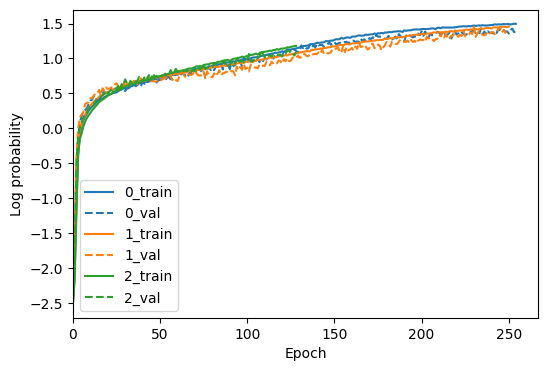

In [21]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(-1.0*np.array(m['training_loss']),
            ls='-', label=f"{i}_train", c=c[i])
    ax.plot(-1.0*np.array(m['validation_loss']),
            ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

Drawing 350 posterior samples: 426it [00:00, 198618.66it/s]           
Drawing 375 posterior samples: 438it [00:00, 277634.15it/s]           
Drawing 275 posterior samples: 361it [00:00, 244650.79it/s]           


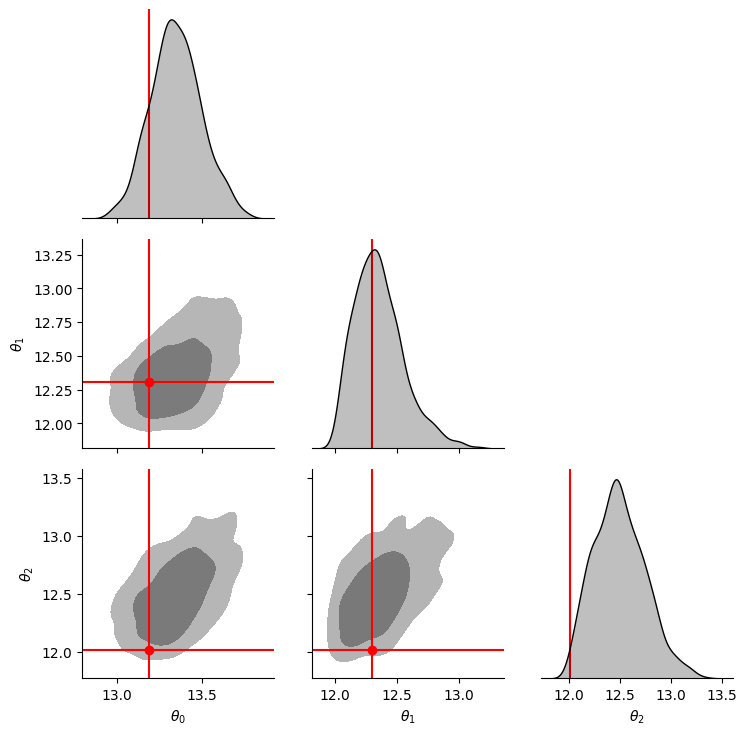

In [22]:
ind = 0
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct',
    labels=[f'$\\theta_{i}$' for i in range(3)]
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs=x[ind], theta_fid=theta[ind],
    plot_kws=dict(fill=True)
)

100%|██████████| 273/273 [00:01<00:00, 231.60it/s]
INFO:root:Mean logprob: 1.4293e+00Median logprob: 1.6520e+00
100%|██████████| 100/100 [00:01<00:00, 56.60it/s]
INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


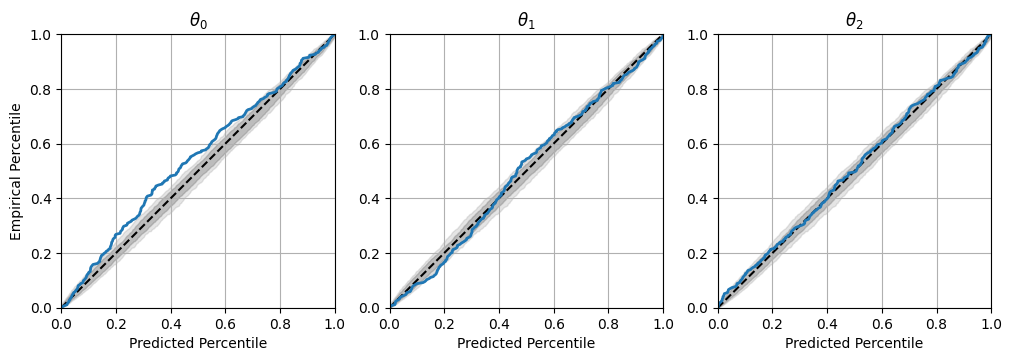

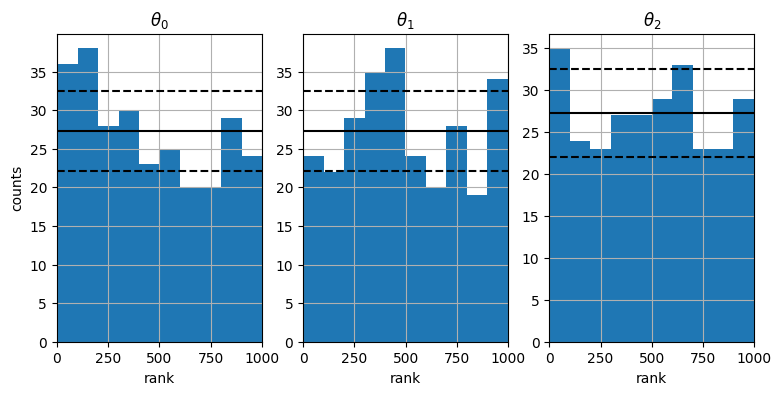

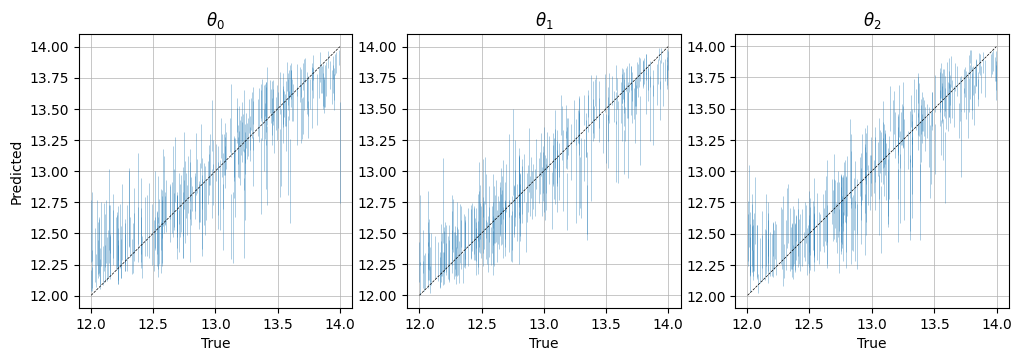

INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


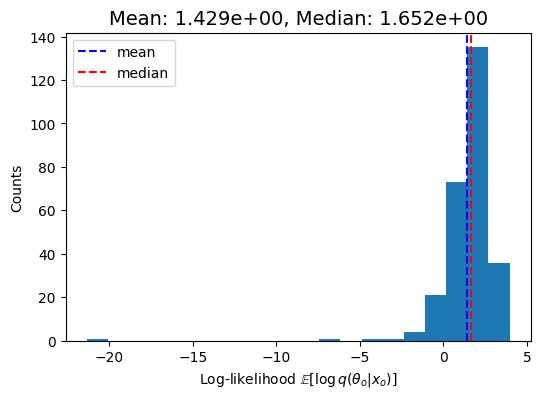

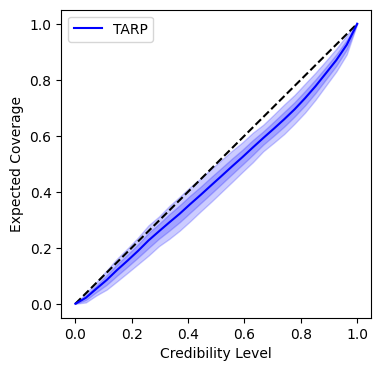

In [23]:
# Drawing samples from the ensemble posterior

metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct',
    labels=[f'$\\theta_{i}$' for i in range(3)],
    plot_list=["coverage", "histogram", "predictions", "tarp", "logprob"],
    out_dir=None
)

fig = metric(
    posterior=posterior_ensemble,  # NeuralPosteriorEnsemble instance from sbi package
    x=x[::11], theta=theta[::11]
)

In [24]:
# Test data


# # SIMBIG
# nbody = 'real_data'
# sim = 'cmass_simbig'
# L, N = 2000, 256
# tracer = 'simbig_lightcone'
# lhid = 0

# # MTNG
# nbody = 'mtng'
# sim = 'nbody'
# L, N = 3000, 384
# tracer = 'mtng_lightcone'
# lhid = 0

# # SGC
# nbody = 'real_data'
# sim = 'cmass_sgc'
# L, N = 2000, 256
# tracer = 'sgc_lightcone'
# lhid = 0

# NGC
nbody = 'real_data'
sim = 'cmass_ngc'
L, N = 3000, 384
tracer = 'ngc_lightcone'
lhid = 0

In [26]:
obs.shape

(1, 100)

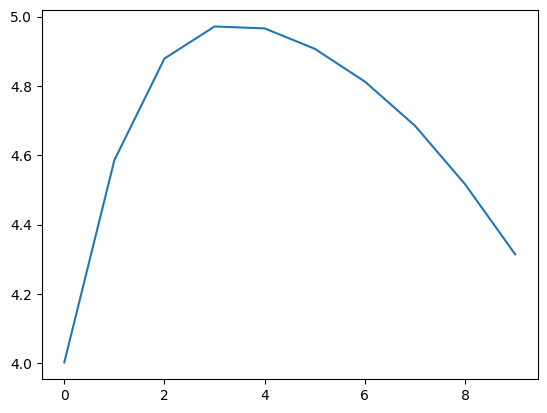

In [28]:
suitedir = join(wdir, nbody, sim, f'L{L}-N{N}')
file = 'hod00000_aug00000.h5'

filepath = join(suitedir, str(lhid), tracer, file)

with h5py.File(filepath, 'r') as f:
    redshifts = f['z'][:]
nzbins = np.linspace(0.4, 0.7, 101)
nzcens = 0.5 * (nzbins[1:] + nzbins[:-1])
nz = np.histogram(redshifts, bins=nzbins)[0]

xobs = np.array([nz])

xobs = np.log10(np.sum(xobs.reshape(len(xobs), -1, 10), axis=-1))


if tracer == 'simbig_lightcone':
    # ignore the 0 redshift bins
    xobs = xobs[:, 1:7]

plt.plot(xobs[0])

Drawing 336 posterior samples: 433it [00:00, 208129.00it/s]           
Drawing 375 posterior samples: 100%|██████████| 375/375 [00:00<00:00, 390579.59it/s]
Drawing 289 posterior samples: 334it [00:00, 190676.13it/s]           


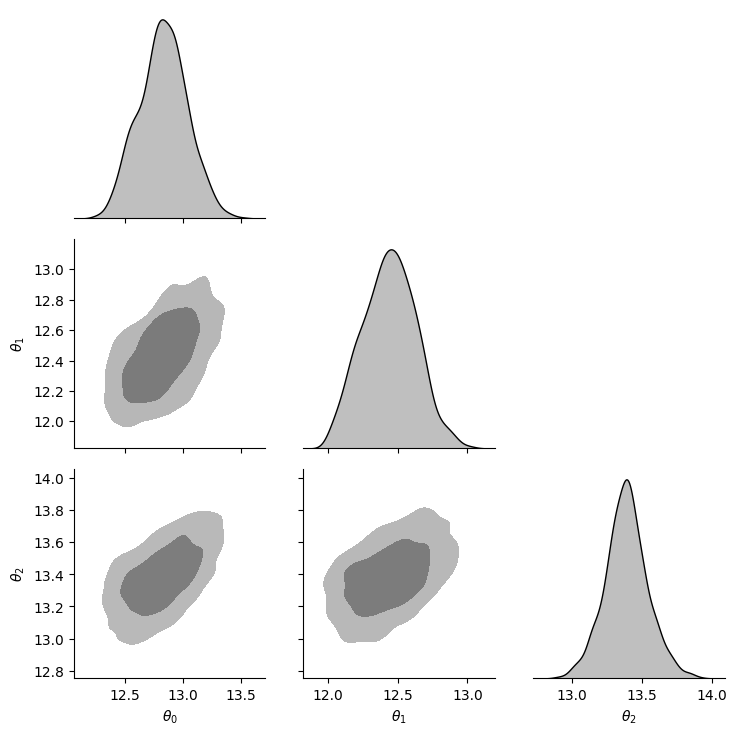

In [29]:
ind = 0
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct',
    labels=[f'$\\theta_{i}$' for i in range(3)]
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs=xobs,
    plot_kws=dict(fill=True)
)

In [30]:
samples = posterior_ensemble.sample(
    (10000,), torch.Tensor(xobs).to(device))
samples = np.array(samples)

print(tracer)
print('Mean:\n', repr(np.mean(samples, axis=0)))
print('Stdev:\n', repr(np.std(samples, axis=0)))
print('Correlation matrix:\n', repr(np.corrcoef(samples.T)))

Drawing 3628 posterior samples: 3706it [00:00, 1315289.44it/s]          
Drawing 3731 posterior samples: 3828it [00:00, 1860031.94it/s]          
Drawing 2641 posterior samples: 2760it [00:00, 1404376.93it/s]          

ngc_lightcone
Mean:
 array([12.835313, 12.455541, 13.390458], dtype=float32)
Stdev:
 array([0.2084813 , 0.19274066, 0.1532904 ], dtype=float32)
Correlation matrix:
 array([[1.        , 0.56047205, 0.5802811 ],
       [0.56047205, 1.        , 0.40978811],
       [0.5802811 , 0.40978811, 1.        ]])
